# Demonstration of python libraries in real case scenario

## Race director

### As input we have 

#### 1) a csv file with the relationship between a RFID chip serial number and their participant number 
#### 2) a csv file with the participant number and their information
#### 3) an unformated txt file with the reading of the RFID ID and their reading time.
#### 4) starting time ----> 10:00:00 am


### As output we need:

#### -> A data base with the results of the event. It is the sequence of the arrival (position), participant data (number)  and time of the race (race time), for all, male, female and unregistered.

#### -> Graphs are needed to show the relationship between male and female regarding race time

#### -> statistical analysis of the event. (min, max, mean)

#### -> An excel file with the results of the event. It is the sequence of the arrival (position), participant data (number)  and time of the race (race time), for all, male, female and unregistered.

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

###### First, stablish steps 

In [1]:
# given the type of file we need to:
# 1) import all our given files
# 2) format our txt file
# 3) create a clean and organized main df 
# 4) add a new column, position
# 5) merge all the dfs into one with all the information for the results
# 6) Clean df and clean race time
# 8) create M and F dfs 
# 9) Graph
# 10) analyse
# 11) export

###### Include all the needed libraries and tools 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time, datetime, csv, xlsxwriter

from openpyxl import Workbook
from openpyxl.drawing.image import Image

from time import gmtime, strftime
from datetime import datetime, timedelta

![separator1](https://i.imgur.com/ZUWYTii.png)

#### 1) Capture input files 

###### It is possibe to introduce Batch ID as a dictionary

In [3]:
# Imclude files
# batch id as a dictionary 
with open('batch.csv', mode='r') as infile:
    reader = csv.reader(infile)
    chip_ID = {rows[1]:rows[0] for rows in reader}

chip_ID.get('5200001')

'1'

###### Or as a dataframe 

In [4]:
df_batch =  pd.read_csv('batch.csv', usecols=['NUMBER', 'CHIP'])
df_batch.loc[df_batch['CHIP']==5200001]

,NUMBER,CHIP
0,1,5200001


###### In the same way, participants as a Dictionary

In [5]:
# include participants info as nested dictionary
f = open('info.csv', 'r',encoding="utf8")
first_line = f.readline()
reader = csv.reader(f)  # omite encabezado
participants = {} # genero lista llamada aretes, es una lista comuesta de listas
for row in reader:
    participants[row[0]] = {'NAME': row[1],'LAST NAME': row[2],'GENDER': row[3]}

In [6]:
participants[str(2)]

{'NAME': 'JUAN', 'LAST NAME': 'JASSO ECHEVERR¡A', 'GENDER': 'M'}

###### or as a dataframe

In [7]:
df_info = pd.read_csv('info.csv', usecols=['NUMBER', 'NAME', 'LAST NAME', 'GENDER'])
df_info.loc[df_info['NUMBER']==2]

,NUMBER,NAME,LAST NAME,GENDER
1385,2,JUAN,JASSO ECHEVERR¡A,M


![separator1](https://i.imgur.com/ZUWYTii.png)

#### 2) Once I have my two main input files ready to be used, we can proceed to format the raw text file 

In [8]:
#as as series of steps
old_file = open('Finish.txt', "r")
lines = old_file.read().split("\n")
new_lines= []
for line in lines:
    newline = line[:7] +',' + line[7:18]   # slicing
    new_lines.append(newline)
old_file.close()

#create an new file txt in order to keep the original intact  
new_file = open('clean_reading.txt', "w")
new_file.write('CHIP,TIME'+"\n")
with new_file:    
    new_file.write("\n".join(new_lines))
new_file.close()

# crate csv from txt file, in order to share the stages of the data with clients 
text_file = pd.read_csv('clean_reading.txt', delimiter = ',')
text_file.to_csv('clean_df.csv', index=False) ######### here I create my df 

#create df from csv 
df = pd.read_csv('clean_df.csv', usecols=['CHIP', 'TIME'])


#### 3) we created a df given our original txt file. The original document is safe and we can proceed with all the work

In [9]:
#we have the columns that we need, but wee can see how seems like we have duplicates
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1079 entries, 0 to 1078
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   CHIP    1079 non-null   int64 
 1   TIME    1079 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.0+ KB


,CHIP,TIME
0,5200829,11:57:26.18
1,5200829,11:57:26.18
2,5200829,11:57:26.18
3,5200230,11:59:57.69
4,5202070,12:01:35.80


#### 4)  in order to be sure about the quality of the df, we origanize by time, and drop duplicates 

In [10]:
df= df.sort_values(by='TIME', ascending=True) # we organize by time, given that this reading may have bugs or miss inputs
df.head()

,CHIP,TIME
0,5200829,11:57:26.18
1,5200829,11:57:26.18
2,5200829,11:57:26.18
3,5200230,11:59:57.69
4,5202070,12:01:35.80


In [11]:
df = df.drop_duplicates(subset = 'CHIP', keep= 'first')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1038 entries, 0 to 1073
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   CHIP    1038 non-null   int64 
 1   TIME    1038 non-null   object
dtypes: int64(1), object(1)
memory usage: 24.3+ KB


In [12]:
# lets keep a record of all the unique readings that we have
all_readings= df['CHIP'].nunique()
all_readings

1038

![separator1](https://i.imgur.com/ZUWYTii.png)
###### Get a draft of the results given the clean reading (chips: time) and the Batch ID (chip:number)

In [13]:

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1038 entries, 0 to 1073
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   CHIP    1038 non-null   int64 
 1   TIME    1038 non-null   object
dtypes: int64(1), object(1)
memory usage: 24.3+ KB


,CHIP,TIME
0,5200829,11:57:26.18
3,5200230,11:59:57.69
4,5202070,12:01:35.80
5,5200141,12:01:57.87
6,5200759,12:02:29.38


We merge our readings with our chip ID batch

In [14]:
df = pd.merge(df, df_batch, on ='CHIP')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1036 entries, 0 to 1035
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   CHIP    1036 non-null   int64 
 1   TIME    1036 non-null   object
 2   NUMBER  1036 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 32.4+ KB


In [15]:
#we can see how from 1038 we went to 1036. We will analize that later 

In [16]:
#Add a column called position, given the time of arrival
df.insert(0, 'POSITION', range(1,len(df)+1))

![separator1](https://i.imgur.com/ZUWYTii.png)
###### Now we update our main df and merge with the participant info

In [17]:
pd.merge(df, df_info, on ='NUMBER').head()

,POSITION,CHIP,TIME,NUMBER,NAME,LAST NAME,GENDER
0,2,5200230,11:59:57.69,230,DAVID CRUZ,VARGAS RODR¡GUEZ,M
1,3,5202070,12:01:35.80,2070,GERARDO,CERVANTES CORNEJO,M
2,4,5200141,12:01:57.87,141,PEDRO,ROSTADO,M
3,5,5200759,12:02:29.38,759,VICTOR,PEREZ ARREOLA,M
4,6,5200083,12:02:29.66,83,BRENDA,ARTEAGA,F


###### Everything looks great, however, if we look closely, the participants with no data are skipped. And that should not happen

In [18]:
# now this will give more accurate results and it will include participants who registered late
df = pd.merge(df, df_info, on ='NUMBER', how ='left')
df.head()

,POSITION,CHIP,TIME,NUMBER,NAME,LAST NAME,GENDER
0,1,5200829,11:57:26.18,829,NaN,NaN,NaN
1,2,5200230,11:59:57.69,230,DAVID CRUZ,VARGAS RODR¡GUEZ,M
2,3,5202070,12:01:35.80,2070,GERARDO,CERVANTES CORNEJO,M
3,4,5200141,12:01:57.87,141,PEDRO,ROSTADO,M
4,5,5200759,12:02:29.38,759,VICTOR,PEREZ ARREOLA,M


#### Now that our df looks good and has all the information, we can proceed with editing the presentation. 
##### First, we drop the chip data from the public results

In [19]:
df = df.drop('CHIP', axis=1)

In [20]:
df.head()

,POSITION,TIME,NUMBER,NAME,LAST NAME,GENDER
0,1,11:57:26.18,829,NaN,NaN,NaN
1,2,11:59:57.69,230,DAVID CRUZ,VARGAS RODR¡GUEZ,M
2,3,12:01:35.80,2070,GERARDO,CERVANTES CORNEJO,M
3,4,12:01:57.87,141,PEDRO,ROSTADO,M
4,5,12:02:29.38,759,VICTOR,PEREZ ARREOLA,M


![separator1](https://i.imgur.com/ZUWYTii.png)
###### Then, we need to fix the time, from hour of arrival into racing time (time of arrival - time of start). However, our TIME attribute is not in the propper format, yet.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1036 entries, 0 to 1035
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   POSITION   1036 non-null   int32 
 1   TIME       1036 non-null   object
 2   NUMBER     1036 non-null   int64 
 3   NAME       770 non-null    object
 4   LAST NAME  770 non-null    object
 5   GENDER     770 non-null    object
dtypes: int32(1), int64(1), object(4)
memory usage: 52.6+ KB


In [22]:
df['TIME']= pd.to_datetime(df['TIME'], format='%H:%M:%S.%f')
df.head()

,POSITION,TIME,NUMBER,NAME,LAST NAME,GENDER
0,1,1900-01-01 11:57:26.180,829,NaN,NaN,NaN
1,2,1900-01-01 11:59:57.690,230,DAVID CRUZ,VARGAS RODR¡GUEZ,M
2,3,1900-01-01 12:01:35.800,2070,GERARDO,CERVANTES CORNEJO,M
3,4,1900-01-01 12:01:57.870,141,PEDRO,ROSTADO,M
4,5,1900-01-01 12:02:29.380,759,VICTOR,PEREZ ARREOLA,M


In [23]:
df['TIME'] = df['TIME'] - pd.Timedelta(hours=10, minutes=0, seconds=0) 
df.head()

,POSITION,TIME,NUMBER,NAME,LAST NAME,GENDER
0,1,1900-01-01 01:57:26.180,829,NaN,NaN,NaN
1,2,1900-01-01 01:59:57.690,230,DAVID CRUZ,VARGAS RODR¡GUEZ,M
2,3,1900-01-01 02:01:35.800,2070,GERARDO,CERVANTES CORNEJO,M
3,4,1900-01-01 02:01:57.870,141,PEDRO,ROSTADO,M
4,5,1900-01-01 02:02:29.380,759,VICTOR,PEREZ ARREOLA,M


In [24]:
df['TIME'] = df['TIME'].dt.strftime('%H:%M:%S')
df.head()

,POSITION,TIME,NUMBER,NAME,LAST NAME,GENDER
0,1,01:57:26,829,NaN,NaN,NaN
1,2,01:59:57,230,DAVID CRUZ,VARGAS RODR¡GUEZ,M
2,3,02:01:35,2070,GERARDO,CERVANTES CORNEJO,M
3,4,02:01:57,141,PEDRO,ROSTADO,M
4,5,02:02:29,759,VICTOR,PEREZ ARREOLA,M


In the real world, we will keep this df as it is, because some participants may introduce their info after the race, or even after the award ceremony. 

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png) 

### Time for some reporting  
###### lets get the results by gender 
But first, we should know if all our data regarding gender is correct. It must be M, F or null.

In [25]:
df['GENDER'].unique()

array([nan, 'M', 'F'], dtype=object)

All good, we may proceed. 

In [26]:
#first we create our female mask 
female_r = df['GENDER']=='F'
female_r

0       False
1       False
2       False
3       False
4       False
        ...  
1031    False
1032    False
1033    False
1034    False
1035    False
Name: GENDER, Length: 1036, dtype: bool

In [27]:
#mask created and applied
f_df = df[female_r]
f_df.head()

,POSITION,TIME,NUMBER,NAME,LAST NAME,GENDER
5,6,02:02:29,83,BRENDA,ARTEAGA,F
9,10,02:13:37,627,ZULEMA,CALDERON CHAVEZ,F
12,13,02:14:58,177,LAURA,HERN NDEZ LE¢N,F
48,49,02:45:49,398,MARTHA PATRICIA,GONZALEZ,F
82,83,02:56:41,2798,JACQUELINE,SOTO ESCALANTE,F


In [28]:
#Here we reset the 'position' column
f_df['POSITION'] = range(1,len(f_df)+1)
f_df.head()

<ipython-input-28-5b51b2b28216>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_df['POSITION'] = range(1,len(f_df)+1)


,POSITION,TIME,NUMBER,NAME,LAST NAME,GENDER
5,1,02:02:29,83,BRENDA,ARTEAGA,F
9,2,02:13:37,627,ZULEMA,CALDERON CHAVEZ,F
12,3,02:14:58,177,LAURA,HERN NDEZ LE¢N,F
48,4,02:45:49,398,MARTHA PATRICIA,GONZALEZ,F
82,5,02:56:41,2798,JACQUELINE,SOTO ESCALANTE,F


![separator1](https://i.imgur.com/ZUWYTii.png)
Repeat the same steps for male

In [29]:
#we create a mask
male_r = df['GENDER']=='M'
male_r

0       False
1        True
2        True
3        True
4        True
        ...  
1031     True
1032    False
1033    False
1034    False
1035     True
Name: GENDER, Length: 1036, dtype: bool

In [30]:
#created and applied
m_df = df[male_r]
m_df.head()

,POSITION,TIME,NUMBER,NAME,LAST NAME,GENDER
1,2,01:59:57,230,DAVID CRUZ,VARGAS RODR¡GUEZ,M
2,3,02:01:35,2070,GERARDO,CERVANTES CORNEJO,M
3,4,02:01:57,141,PEDRO,ROSTADO,M
4,5,02:02:29,759,VICTOR,PEREZ ARREOLA,M
7,8,02:06:41,439,OCIEL,PEREZ,M


In [31]:
#reset the position values
m_df['POSITION']=range(1,len(m_df)+1)
m_df.head()

<ipython-input-31-a2c9ccf806b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_df['POSITION']=range(1,len(m_df)+1)


,POSITION,TIME,NUMBER,NAME,LAST NAME,GENDER
1,1,01:59:57,230,DAVID CRUZ,VARGAS RODR¡GUEZ,M
2,2,02:01:35,2070,GERARDO,CERVANTES CORNEJO,M
3,3,02:01:57,141,PEDRO,ROSTADO,M
4,4,02:02:29,759,VICTOR,PEREZ ARREOLA,M
7,5,02:06:41,439,OCIEL,PEREZ,M


![separator1](https://i.imgur.com/ZUWYTii.png)
 Finally, repeat for non registered

In [32]:
non_r = pd.isnull(df['GENDER'])
non_r

0        True
1       False
2       False
3       False
4       False
        ...  
1031    False
1032     True
1033     True
1034     True
1035    False
Name: GENDER, Length: 1036, dtype: bool

In [33]:
#created and applied
nonr_df = df[non_r]
nonr_df.head()

,POSITION,TIME,NUMBER,NAME,LAST NAME,GENDER
0,1,01:57:26,829,NaN,NaN,NaN
6,7,02:04:56,830,NaN,NaN,NaN
10,11,02:13:41,2455,NaN,NaN,NaN
32,33,02:36:46,813,NaN,NaN,NaN
33,34,02:36:46,812,NaN,NaN,NaN


In [34]:
#reset the position values
nonr_df['POSITION']=range(1,len(nonr_df)+1)
nonr_df.head()

<ipython-input-34-ba9a597cd6ee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonr_df['POSITION']=range(1,len(nonr_df)+1)


,POSITION,TIME,NUMBER,NAME,LAST NAME,GENDER
0,1,01:57:26,829,NaN,NaN,NaN
6,2,02:04:56,830,NaN,NaN,NaN
10,3,02:13:41,2455,NaN,NaN,NaN
32,4,02:36:46,813,NaN,NaN,NaN
33,5,02:36:46,812,NaN,NaN,NaN


In [35]:
#We can drop name, last name and gender 
nonr_df = nonr_df.drop(columns=['NAME', 'LAST NAME', 'GENDER'])
nonr_df.head()

,POSITION,TIME,NUMBER
0,1,01:57:26,829
6,2,02:04:56,830
10,3,02:13:41,2455
32,4,02:36:46,813
33,5,02:36:46,812


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png) 

### Time for some graphs
##### 9) Because no report is complete without graphs

In [36]:
#first, lets see how was the distribution among our participants
# lets consider all our unique readings as a 100%
# this measn all our female, male and unregistered readings should add '1038'.
# lets check it

female_readings = f_df['NUMBER'].nunique()
male_readings = m_df['NUMBER'].nunique()
nonr_readings = nonr_df['NUMBER'].nunique() 
female_readings + male_readings + nonr_readings
tot_r= female_readings + male_readings + nonr_readings
no_chip= all_readings - tot_r
tot_r

1036

In [37]:
#there are 2 participants who used unregistered chips

![separator1](https://i.imgur.com/ZUWYTii.png)
### Pie Chart

In [38]:
participation_df = pd.DataFrame({'Categories': ['Female', 'Male', 'Unregistered', 'no chip'],
                                'Participation':[female_readings, male_readings,
                                            nonr_readings, no_chip]})




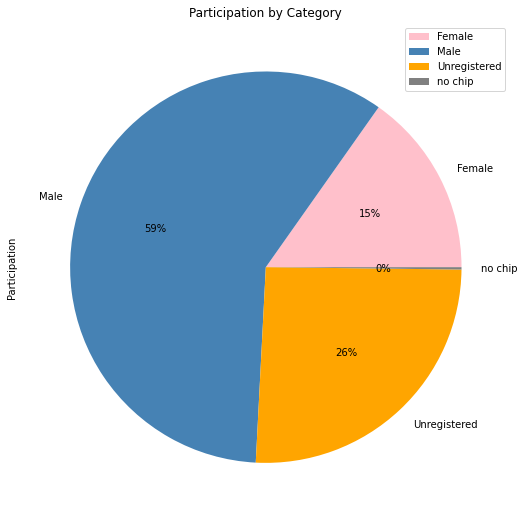

In [39]:
participation_df.groupby(['Categories']).sum().plot(kind='pie', y='Participation', 
                                                    autopct='%1.0f%%', figsize=(9, 9),
                                colors = ['pink', 'steelblue', 'orange','gray'],
                                title='Participation by Category')


![separator1](https://i.imgur.com/ZUWYTii.png)
### Distribution

Now, this chart will be a little bit more tricky. We need to visualize the ratio of arrrivals per hour.

In [40]:
#  use time for X axis
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1036 entries, 0 to 1035
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   POSITION   1036 non-null   int32 
 1   TIME       1036 non-null   object
 2   NUMBER     1036 non-null   int64 
 3   NAME       770 non-null    object
 4   LAST NAME  770 non-null    object
 5   GENDER     770 non-null    object
dtypes: int32(1), int64(1), object(4)
memory usage: 52.6+ KB


In [41]:
# Create a copy to be modified
df_copy=df.copy()

In [42]:
#take time index, now it will be the x axis
df_copy['TIME']= pd.to_datetime(df_copy['TIME'], format='%H:%M:%S')

# Set the 'arrival_time' column as the index of the data frame
df_copy.set_index('TIME', inplace=True)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1036 entries, 1900-01-01 01:57:26 to 1900-01-01 06:45:03
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   POSITION   1036 non-null   int32 
 1   NUMBER     1036 non-null   int64 
 2   NAME       770 non-null    object
 3   LAST NAME  770 non-null    object
 4   GENDER     770 non-null    object
dtypes: int32(1), int64(1), object(3)
memory usage: 44.5+ KB


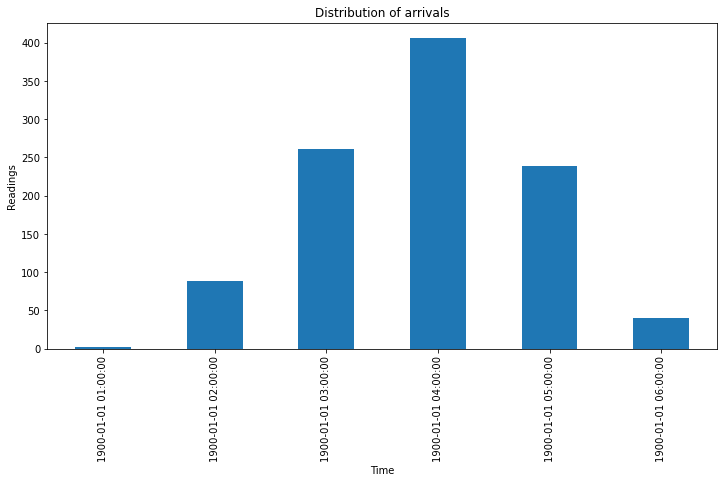

In [43]:
# Resample the data frame per 60 minutes and count the number of arrivals in each interval
arrivals_per_60min = df_copy['NUMBER'].resample('60T').count()

# Plot the distribution chart
arrivals_per_60min.plot(kind='bar', legend=None, figsize=(12, 6))

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Readings')
plt.title('Distribution of arrivals')

# Display the plot
plt.show()

Lets get a more definded shape

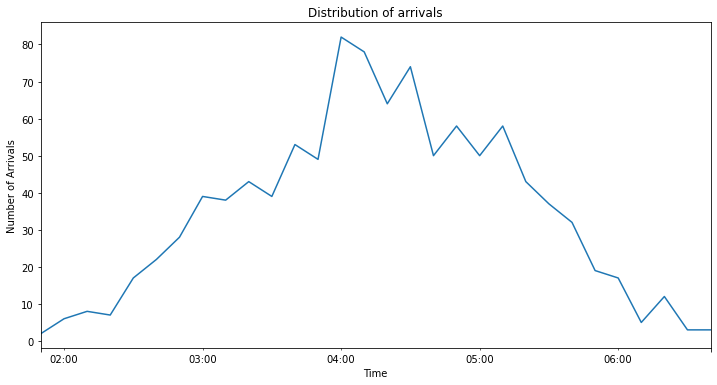

In [44]:
# Resample the data frame per 10 minutes and count the number of arrivals in each interval
arrivals_per_10min = df_copy['NUMBER'].resample('10T').count()

# Plot the distribution chart
arrivals_per_10min.plot(kind='line', legend=None, figsize=(12, 6))

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Number of Arrivals')
plt.title('Distribution of arrivals')

# Display the plot
plt.show()

Nice, we can almost see the bell curve of distribution.

#### lets overlap the graph for all categories 

In [45]:
# Resample the data frame per 10 minutes and count the number of arrivals in each interval per group
farrivals_per_10min = df_copy[df_copy['GENDER']=='F']['NUMBER'].resample('10T').count()
marrivals_per_10min = df_copy[df_copy['GENDER']=='M']['NUMBER'].resample('10T').count()
narrivals_per_10min = df_copy[pd.isnull(df_copy['GENDER'])]['NUMBER'].resample('10T').count()

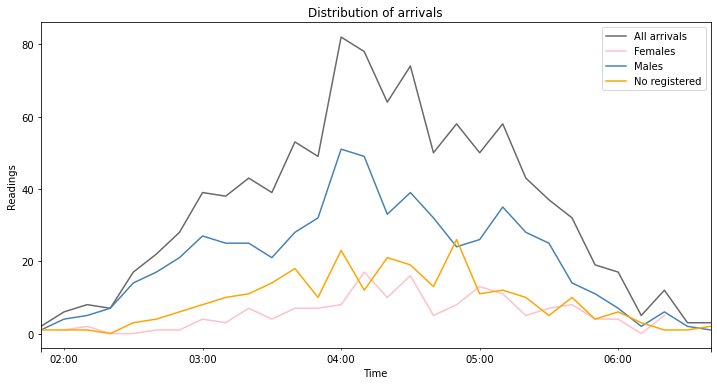

In [46]:
# Graph with global API
plt.figure(figsize=(12, 6))

# Plot the distribution chart
arrivals_per_10min.plot(kind='line', legend=None,  c= 'dimgray')
farrivals_per_10min.plot(kind='line', legend=None, c='pink')
marrivals_per_10min.plot(kind='line', legend=None, c='steelblue')
narrivals_per_10min.plot(kind='line', legend=None, c= 'orange')


# Customize the plot
plt.xlabel('Time')
plt.ylabel('Readings')
plt.title('Distribution of arrivals')

#legend
plt.legend(['All arrivals', 'Females', 'Males', 'No registered'],
            loc='upper right')

#create and save image
plt.savefig("distribution.png", dpi=600)


# Display the plot
plt.show()

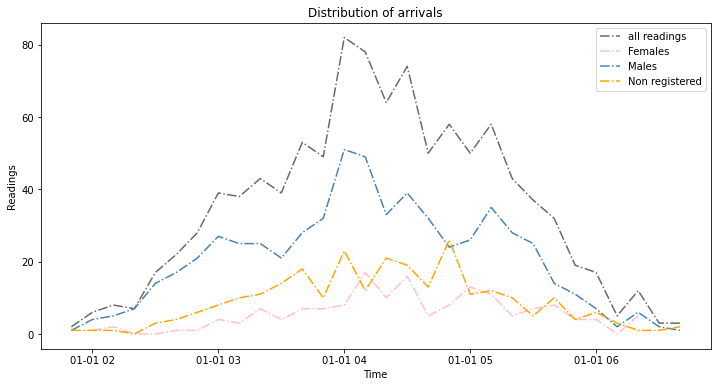

In [47]:
# graph with OOP (just because)
fig, axes = plt.subplots(figsize=(12, 6))

# Plot the distribution chart
axes.plot(arrivals_per_10min, c= 'dimgray', linestyle= 'dashdot', label="all readings")
axes.plot(farrivals_per_10min, c='pink', linestyle='dashdot', label="Females")
axes.plot(marrivals_per_10min, c='steelblue',linestyle='dashdot', label="Males")
axes.plot(narrivals_per_10min, c= 'orange', linestyle='dashdot',label="Non registered")

# Customize the plot
axes.set_title("Distribution of arrivals")
axes.set_xlabel("Time")
axes.set_ylabel("Readings")
axes.legend()

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png) 
### Statistics 
##### 10) create a data frame with all the relevant information per group
In order to do so, lets do it by parts


In [48]:
#create the data frame
stats_df = pd.DataFrame({'Participation':
                          [female_readings,
                          male_readings,
                          nonr_readings,
                          tot_r],
                          'Min_Time':
                          [1,2,3,4],
                          'Max_Time':
                          [1,2,3,4],
                          "Mean_Time":
                          [1,2,3,4]
}, columns=['Participation','Min_Time','Max_Time', "Mean_Time"])

In [49]:
# add the index column 
stats_df.index = [
    'Female',
    'Male',
    'non registered',
    'All'
]
stats_df

,Participation,Min_Time,Max_Time,Mean_Time
Female,158,1,1,1
Male,612,2,2,2
non registered,266,3,3,3
All,1036,4,4,4


In [50]:
#it has the needed shape, valaues can be replaced now
stats_df['Min_Time'] = stats_df['Min_Time'].replace(to_replace= [1,2,3,4],
                                                    value=[f_df['TIME'].min(),
                                                           m_df['TIME'].min(),
                                                           nonr_df['TIME'].min(),
                                                           df['TIME'].min()])
                                                           
stats_df['Max_Time'] = stats_df['Max_Time'].replace(to_replace= [1,2,3,4],
                                                    value=[f_df['TIME'].max(),
                                                           m_df['TIME'].max(),
                                                           nonr_df['TIME'].max(),
                                                           df['TIME'].max()])


stats_df

,Participation,Min_Time,Max_Time,Mean_Time
Female,158,02:02:29,06:28:15,1
Male,612,01:59:57,06:45:03,2
non registered,266,01:57:26,06:43:09,3
All,1036,01:57:26,06:45:03,4


In [51]:
#next operations are with time, so they need an extra step, 
#changing the datatype to date time

#change to datetime
tfdf = pd.to_datetime(f_df['TIME'], infer_datetime_format=True).mean()
tmdf = pd.to_datetime(m_df['TIME'], infer_datetime_format=True).mean()
tadf = pd.to_datetime(df['TIME'], infer_datetime_format=True).mean()
tnrdf = pd.to_datetime(nonr_df['TIME'], infer_datetime_format=True).mean()


In [52]:
#however, this gives a Time stamp datatype with irrelavant data
tfdf

Timestamp('2023-07-10 04:36:29.050632448')

In [53]:
#transforming from timestamp to string, or object to be more precise
tfdf.strftime('%X')

'04:36:29'

In [54]:
#replace values
stats_df['Mean_Time'] = stats_df['Mean_Time'].replace(to_replace = [1,2,3,4],
                                                    value=[tfdf.strftime('%X')
                                                           ,tmdf.strftime('%X')
                                                           ,tadf.strftime('%X')
                                                           ,tnrdf.strftime('%X')])
stats_df.head()


,Participation,Min_Time,Max_Time,Mean_Time
Female,158,02:02:29,06:28:15,04:36:29
Male,612,01:59:57,06:45:03,04:16:25
non registered,266,01:57:26,06:43:09,04:21:40
All,1036,01:57:26,06:45:03,04:24:56


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png) 

### Saving the results as excel files

##### 11) Given the 5 clean data frames and the graphs produced , results can be exported. 

Exporting Graph

In [55]:
workbook   = xlsxwriter.Workbook('Results.xlsx')

worksheetstats = workbook.add_worksheet('Graphs')

worksheetstats.insert_image('C4', 'distribution.png')

workbook.close()

Exporting Data frames

In [56]:
with pd.ExcelWriter('Results.xlsx', engine="openpyxl",mode='a') as writer:
    df.to_excel(writer, index=None, sheet_name='All participants', startrow=2, startcol=2) 
    f_df.to_excel(writer, index=None, sheet_name='Females', startrow=2, startcol=2)
    m_df.to_excel(writer, index=None, sheet_name='Males', startrow=2, startcol=2)
    nonr_df.to_excel(writer, index=None, sheet_name='Non registered', startrow=2, startcol=2)
    stats_df.to_excel(writer, index=None, sheet_name='Statistics', startrow=2, startcol=2)
    
    

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png) 
### Insights 